# Model comparison to GLODAP along GO-SHIP Easy Ocean lines
This notebook shows a means of comparing MOM6 ocean model data to GLODAP data along the WOCE/GO-SHIP sections. GLODAP data are taken from the cruises used to construct the Easy Ocean lines. Model data are interpolated onto the cruis station locations using `xesmf`. See [here](https://www.glodap.info/) for information on GLODAP, and [here](https://cchdo.ucsd.edu/products/goship-easyocean) for information on the Easy Ocean lines.

In [1]:
plotsdir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/figures/" + x

In [2]:
import pandas as pd
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean

In [3]:
from geopy import distance


In [4]:
import xesmf as xe
import sectionate

In [5]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmolkg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmolkg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'PuRd','units':'fmolkg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [6]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='192GB',
    walltime='02:00:00',
    queue='scavenger',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=16)
from dask.distributed import Client
client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p scavenger
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=179G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/bin/python -m distributed.cli.dask_worker tcp://172.16.3.66:36565 --nthreads 36 --memory-limit 178.81GiB --name dummy-name --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.66:36565,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [79]:
def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":10, "longitude":10, "zl":-1, "year":-1},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

ds = read_CM4X("../../CM4Xp25_historical_transient_tracers.zarr")
ds = ds.drop(["lat", "lon"])
ds = ds.rename({"geolat":"lat", "geolon":"lon"})
ds["z"] = ds["z"].transpose("year", "zl", "yh", "xh")
ds["thkcello"] = ds["thkcello"].transpose("year", "zl", "yh", "xh")
# ds = ds.where(ds['thkcello'] > 9.999975e-3)  
# # 
#need to interpolate zl to z next 

In [8]:
def time_z_mean(ds, ystart, yend, zmin, zmax):
    ds_tmp = ds.sel(year = slice(ystart, yend)).mean(["year"]).compute()
    ds_mean = ds_tmp.cfc12
    ds_z_mean = ds_tmp.z
    ds_thick_mean = ds_tmp.thkcello
    
    mask = (ds_z_mean > zmin) * (ds_z_mean < zmax)
    weights = mask * ds_thick_mean

    ds_mean_level = (weights * ds_mean).sum("zl") / weights.sum("zl")
    return ds_mean_level * variable_kwargs['cfc12']['conversion']

In [103]:
def z_mean(ds, var, zmin, zmax):
    ds_tmp = ds
    ds_mean = ds_tmp[var]
    ds_z_mean = ds_tmp.z
    ds_thick_mean = ds_tmp.thkcello
    
    mask = (ds_z_mean > zmin) * (ds_z_mean < zmax)
    weights = mask * ds_thick_mean

    ds_mean_level = (weights * ds_mean).sum("zl") / weights.sum("zl")
    return ds_mean_level * variable_kwargs['cfc12']['conversion']

In [9]:
ds_GLODAPP = xr.open_dataset("GLODAP_gridded.nc")
ds_GLODAPP = ds_GLODAPP.rename({"G2cfc12":"cfc12", "G2cfc11":"cfc11", "G2sf6":"sf6", 
                  "G2temperature":"temperature", "G2salinity":"salinity"})

In [115]:
cfc_gridded = ds_GLODAPP.sel(lon = slice(90, 100), 
                                   lat = slice(-35, -30))

cfc_gridded = cfc_gridded.mean(["lat", "lon"]).cfc11

In [116]:
ds_tmp = ds.sel(xh = slice(90 - 360, 100-360), yh = slice(-35, -30)).compute()
mask = (ds_tmp.lon < (100-360)) * (ds_tmp.lon > (90-360)) * (ds_tmp.lat < -30) * (ds_tmp.lat > -35)
weights = mask * ds_tmp.thkcello
ts_sample = (weights * ds_tmp).sum(["xh", "yh"]) / weights.sum(["xh", "yh"])
ts_sample = ts_sample.compute()

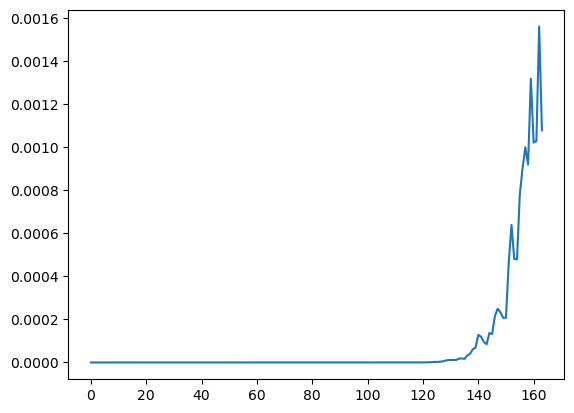

In [128]:
ts = (z_mean(ts_sample, "cfc11", -6000, -3000)).values
dts = ts[1:] - ts[:-1]
plt.plot(dts)

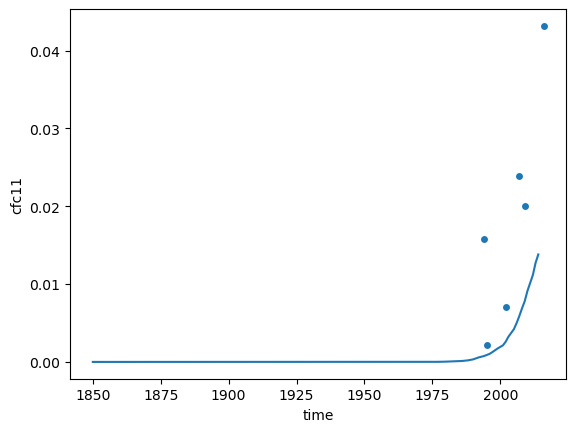

In [118]:
(z_mean(ts_sample, "cfc11", -3500, -3000)).plot()
cfc_gridded.sel(z = 3000, method = "nearest").drop("z").plot.scatter()
# cfc_gridded.sel(z = 3000, method = "nearest").drop("z").plot.scatter()

In [ ]:
Y = cfc12_weighted.z.values
Y[np.isnan(Y)] = 10 
X, _ = np.meshgrid(ds.year, ds.zl)

/tmp/ipykernel_203251/4221710498.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X.T,Y, cfc12_weighted.cfc12 * variable_kwargs["cfc11"]["conversion"], vmin = 0, vmax = 1)


(-6000.0, 0.0)

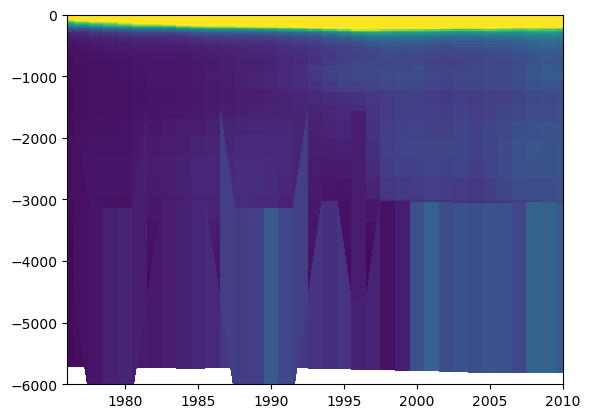

In [ ]:
plt.pcolormesh(X.T,Y, cfc12_weighted.cfc12 * variable_kwargs["cfc11"]["conversion"], vmin = 0, vmax = 1)
plt.xlim(1976, 2010)
plt.ylim(-6000, 0)


In [ ]:
tmp = ds.sel(xh = -30, yh = -65, method = "nearest").compute()

In [ ]:
Y = tmp.z.values
Y[np.isnan(Y)] = 10 
X, _ = np.meshgrid(tmp.year, tmp.zl)

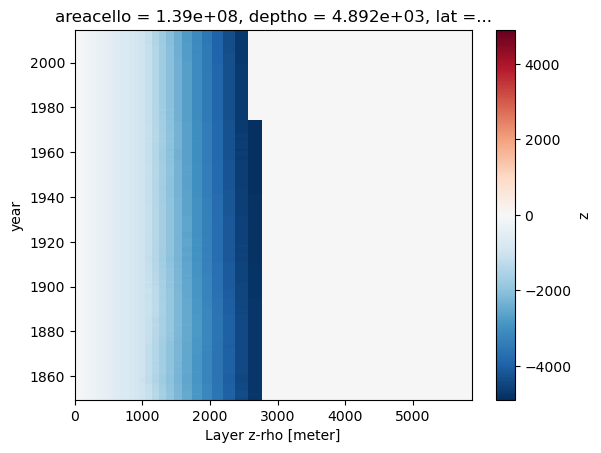

In [ ]:
tmp.z.plot()

/tmp/ipykernel_203251/2201622572.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X.T,Y, tmp.cfc12* variable_kwargs["cfc11"]["conversion"], vmin = 0, vmax = 1)


(-6000.0, 0.0)

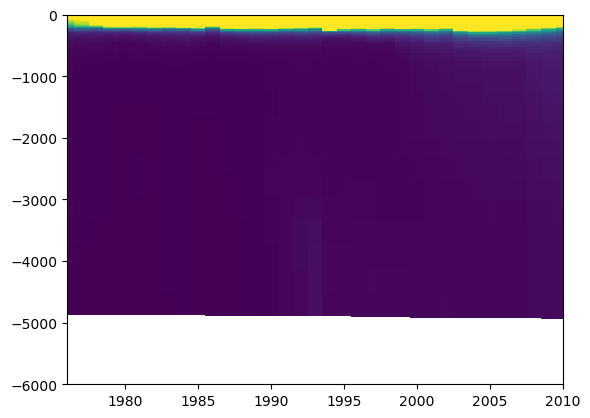

In [ ]:
plt.pcolormesh(X.T,Y, tmp.cfc12* variable_kwargs["cfc11"]["conversion"], vmin = 0, vmax = 1)
plt.xlim(1976, 2010)
plt.ylim(-6000, 0)